### Case - [Pierre-Antoine Denarié]

### TL;DR
Objective: predict the time it takes for a bus to travel from first to final stop, at any given point in the future.

Points to work out:
- correlation between checkin data & scheduling ties length/delta in prediction --> create feature delta time
- Join checkin data with scheduling data --> PCA
- correlation between stoparea code & join of number of checkins during said Journey

Plots:
- plot checkins over time

features to create:
- split checkin data
- feature delta time


### Housekeeping & Imports

In [1]:
# Clear all variables from the workspace
%reset -f

In [2]:
### Package Imports
# System
from __future__ import annotations
import os
from pathlib import Path
import re
import logging
from typing import Dict
from functools import partial

# Data
import numpy as np
import pandas as pd

# Own packages
from src.myfunctions import *

# Import visualisation libraries
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from IPython.display import display
import seaborn as sns

# Pretty display for notebooks
%matplotlib inline

# Setup Logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")


INFO: Pandas backend loaded 2.3.1
INFO: Numpy backend loaded 2.1.3
INFO: Pyspark backend NOT loaded
INFO: Python backend loaded
INFO: Numpy backend loaded 2.1.3
INFO: Pyspark backend NOT loaded
INFO: Python backend loaded


In [3]:
# Parameter
DATA_DIR = "Data"
DATA_RAW_DIR = DATA_DIR + "/Raw"
PROCESSED_DIR = DATA_DIR + "/Processed"

REPORTS : str = "Reports"
PROFILING : str = REPORTS + "/Profiling"

### Data Loading

In [4]:
# Clean Data imports
dfs = load_csv_folder(DATA_RAW_DIR)
print(dfs.keys())

INFO: Loaded bus_trips from bus_trips.csv | shape=(591766, 11)
INFO: Loaded check_ins from check_ins.csv | shape=(41923, 2)
INFO: Loaded stops from stops.csv | shape=(5636, 3)


dict_keys(['bus_trips', 'check_ins', 'stops'])


### Data exploration

In [5]:
# Generate profling reports
df_profiles = generate_profiling_reports(dfs, title="Data Profiling Report")

INFO: Generated profiling report for bus_trips
INFO: Generated profiling report for check_ins
INFO: Generated profiling report for stops


In [6]:
# View profiling reports
display_profiling_reports_web(profiles=df_profiles)

INFO: Opened profiling report for bus_trips
INFO: Opened profiling report for check_ins
INFO: Opened profiling report for stops


In [5]:
# DProcess & display time series data
pipeline = {
    "check_ins": [
        Step("add_feature", when=has_cols("id"), fn=partial(add_feature, src="id", dest='id_Datetime', function=parse_time_column))
    ]
}

dfs_processed = run_pipeline(dfs, pipeline)
display_profiling_reports_web(generate_profiling_reports(dfs_processed, title="Data Profiling Processed Report", timeseries=True, sortby="id_Datetime"), refresh_results=False)


INFO: ▶ bus_trips: 0 steps
INFO: ▶ check_ins: 1 steps
INFO:   - add_feature: (41923, 2) -> (41923, 3) (147 ms)
INFO: ▶ stops: 0 steps
ERROR: Error generating profiling report for bus_trips: 'id_Datetime'
INFO: Generated profiling report for check_ins
ERROR: Error generating profiling report for stops: 'id_Datetime'
INFO: Opened profiling report for check_ins


In [6]:
## closer inspection of duplicate rows by a single example
inspect_duplicate_rows(dfs['bus_trips'], 3122)

,lineplanningnumber,journeynumber,vehiclenumber,userstopcode_start,userstopcode_end,messagetype_begin,messagetype_end,operatingday,departure_time,realized_time,planned_time
3122,1,1005,5149,54261502,53490410,DEPARTURE,ARRIVAL,2021-09-08,2021-09-08 07:07:24,00:32:54,00:32:58
74041,1,1005,5149,54261502,53490410,DEPARTURE,ARRIVAL,2021-09-08,2021-09-08 07:07:24,00:32:54,00:32:58
144960,1,1005,5149,54261502,53490410,DEPARTURE,ARRIVAL,2021-09-08,2021-09-08 07:07:24,00:32:54,00:32:58
215879,1,1005,5149,54261502,53490410,DEPARTURE,ARRIVAL,2021-09-08,2021-09-08 07:07:24,00:32:54,00:32:58


before removing the duplicates, let's check if there is perhaps not an uderlying reason why there are duplicates. For example, bus with multiple vehicle stages.
Let's check this by investigating the correlation between the time delta & when there is a duplicate or not

In [5]:
df_processed = add_time_delta(dfs['bus_trips'], 'realized_time', 'planned_time', return_series=False)

In [22]:
dr1 = pd.merge(df_processed, dfs['stops'].rename(columns=lambda x: x + '_start' if x != 'key_column' else x),
                left_on='userstopcode_start', right_on='userstopcode_start', suffixes=('', '_start'))

dr1 = pd.merge(dr1, dfs['stops'].rename(columns=lambda x: x + '_end' if x != 'key_column' else x),
                left_on='userstopcode_end', right_on='userstopcode_end', suffixes=('', '_end'))

dr1.head(5)

,lineplanningnumber,journeynumber,vehiclenumber,userstopcode_start,userstopcode_end,messagetype_begin,messagetype_end,operatingday,departure_time,realized_time,planned_time,time_delta,userstopareacode_start,stopname_start,userstopareacode_end,stopname_end
0,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-12,2023-12-12 06:16:39,00:27:33,00:30:55,-202.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum"
1,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-13,2023-12-13 06:14:19,00:29:25,00:30:56,-91.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum"
2,1,1001,5115,54261502,53490410,DEPARTURE,ARRIVAL,2023-10-31,2023-10-31 06:15:00,00:29:49,00:30:57,-68.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum"
3,1,1001,5120,54261502,53490410,DEPARTURE,ARRIVAL,2023-02-08,2023-02-08 06:13:18,00:29:06,00:31:56,-170.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum"
4,1,1001,5121,54261502,53490410,DEPARTURE,ARRIVAL,2022-01-17,2022-01-17 06:13:19,00:30:54,00:32:54,-120.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum"


In [27]:
dfs['bus_trips']['userstopcode_end'][dfs['bus_trips']['lineplanningnumber']==1].value_counts()

userstopcode_end
54261506    144796
53490410    138880
Name: count, dtype: int64[pyarrow]

In [7]:
dr2 = duplicate_count_per_row(df=dr1, return_series=False)
dr2['duplicate_count'].unique()

<ArrowExtensionArray>
[4, 2, 1]
Length: 3, dtype: int64[pyarrow]

In [8]:
desc = {}

for i,val in enumerate(dr2['duplicate_count'].unique()):
    desc[f'No of duplicates {val}'] = dr2['time_delta'][dr2['duplicate_count'] == val].describe()


# Combine as columns in a DataFrame
combined = pd.concat(desc.values(), axis=1)
combined.columns = desc.keys()

combined

,No of duplicates 4,No of duplicates 2,No of duplicates 1
count,283672.000000,308080.000000,14.000000
mean,-68.043487,-121.383595,-56.071429
std,187.197606,119.117670,63.793494
min,-2038.000000,-3099.000000,-164.000000
25%,-163.000000,-189.000000,-97.500000
50%,-81.000000,-131.000000,-62.500000
75%,-3.000000,-69.000000,-1.750000
max,3851.000000,3723.000000,37.000000


In [ ]:
pd.to_datetime(dr2['departure_time']).dt.floor('H')

C:\Users\pierr\AppData\Local\Temp\ipykernel_6196\1733799745.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.to_datetime(dr2['departure_time']).dt.floor('H')


0        2023-12-12 06:00:00
1        2023-12-13 06:00:00
2        2023-10-31 06:00:00
3        2023-02-08 06:00:00
4        2022-01-17 06:00:00
                 ...        
591761   2019-12-23 23:00:00
591762   2020-03-25 23:00:00
591763   2020-06-09 23:00:00
591764   2020-08-04 23:00:00
591765   2020-08-20 23:00:00
Name: departure_time, Length: 591766, dtype: datetime64[ns]

-------------

In [59]:
# Plot departure times throughout the day & compare with checkins -  Daily cycle
totals_single_day = pd.to_datetime(dr2['departure_time']).dt.floor('h').dt.time.value_counts().sort_index()

In [70]:
df_temp = dfs_processed['check_ins'][['id_Datetime','number_of_check_ins']]
df_temp['id_Datetime'] = df_temp['id_Datetime'].dt.time

average_checkings_single_day = df_temp.groupby('id_Datetime').mean()*1000

C:\Users\pierr\AppData\Local\Temp\ipykernel_10260\580706005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['id_Datetime'] = df_temp['id_Datetime'].dt.time


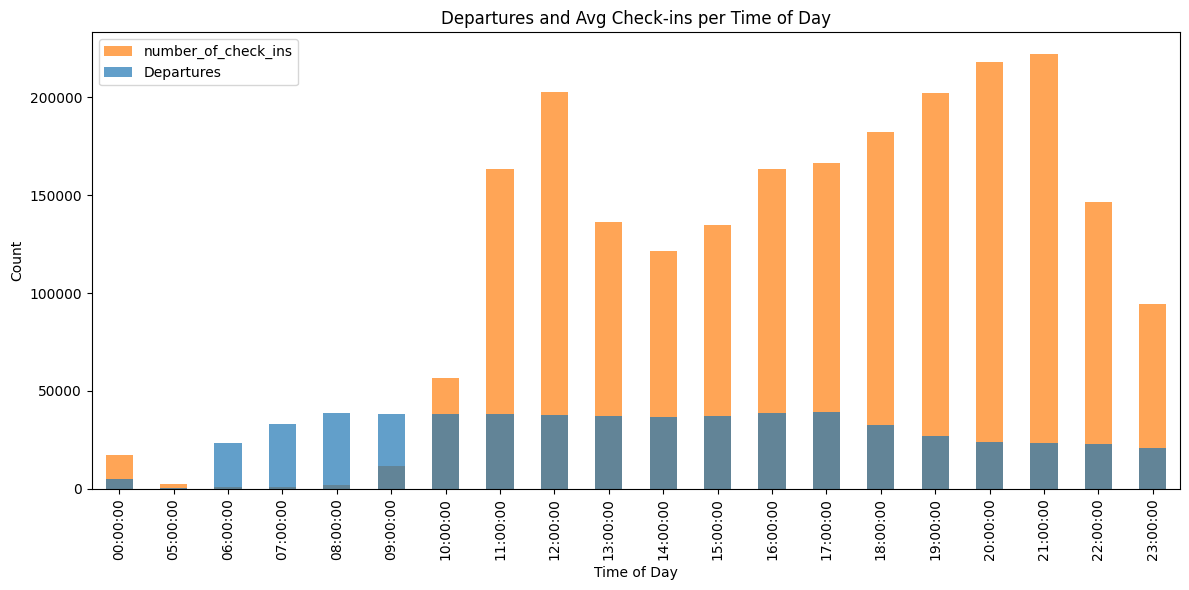

In [71]:
# Plot both series on the same figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
average_checkings_single_day.plot(kind='bar', color='tab:orange', alpha=0.7, label='Avg Check-ins', ax=ax)
totals_single_day.plot(kind='bar', color='tab:blue', alpha=0.7, label='Departures', ax=ax)
ax.set_xlabel('Time of Day')
ax.set_ylabel('Count')
ax.set_title('Departures and Avg Check-ins per Time of Day')
ax.legend()
plt.tight_layout()
plt.show()

In [75]:
dr2.head(5)

,lineplanningnumber,journeynumber,vehiclenumber,userstopcode_start,userstopcode_end,messagetype_begin,messagetype_end,operatingday,departure_time,realized_time,planned_time,time_delta,userstopareacode_start,stopname_start,userstopareacode_end,stopname_end,duplicate_count
0,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-12,2023-12-12 06:16:39,00:27:33,00:30:55,-202.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4
1,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-13,2023-12-13 06:14:19,00:29:25,00:30:56,-91.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4
2,1,1001,5115,54261502,53490410,DEPARTURE,ARRIVAL,2023-10-31,2023-10-31 06:15:00,00:29:49,00:30:57,-68.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4
3,1,1001,5120,54261502,53490410,DEPARTURE,ARRIVAL,2023-02-08,2023-02-08 06:13:18,00:29:06,00:31:56,-170.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4
4,1,1001,5121,54261502,53490410,DEPARTURE,ARRIVAL,2022-01-17,2022-01-17 06:13:19,00:30:54,00:32:54,-120.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4


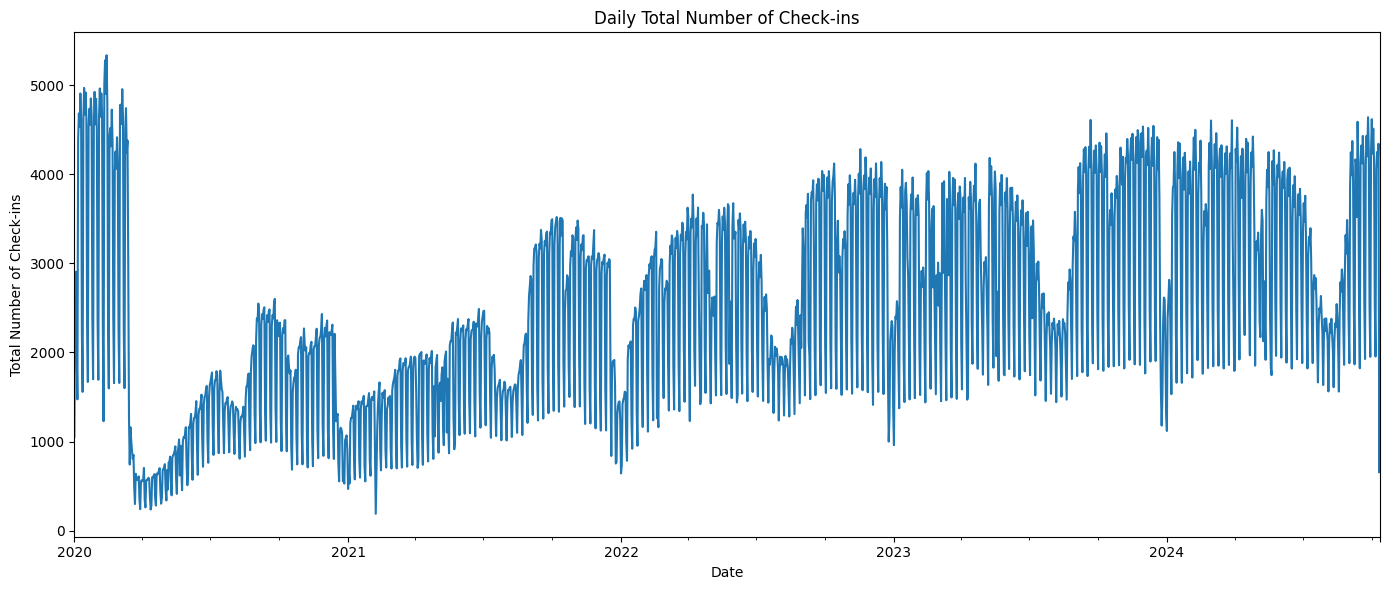

,lineplanningnumber,journeynumber,vehiclenumber,userstopcode_start,userstopcode_end,messagetype_begin,messagetype_end,operatingday,departure_time,realized_time,planned_time,time_delta,userstopareacode_start,stopname_start,userstopareacode_end,stopname_end,duplicate_count
0,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-12,2023-12-12 06:16:39,00:27:33,00:30:55,-202.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4
1,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-13,2023-12-13 06:14:19,00:29:25,00:30:56,-91.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4
2,1,1001,5115,54261502,53490410,DEPARTURE,ARRIVAL,2023-10-31,2023-10-31 06:15:00,00:29:49,00:30:57,-68.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4
3,1,1001,5120,54261502,53490410,DEPARTURE,ARRIVAL,2023-02-08,2023-02-08 06:13:18,00:29:06,00:31:56,-170.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4
4,1,1001,5121,54261502,53490410,DEPARTURE,ARRIVAL,2022-01-17,2022-01-17 06:13:19,00:30:54,00:32:54,-120.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591761,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2019-12-23,2019-12-23 23:45:24,00:09:16,00:12:56,-220.0,dftabt,"Delft, Abtswoudsepark",dftcs,"Delft, Station Delft",2
591762,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-03-25,2020-03-25 23:46:42,00:08:23,00:12:55,-272.0,dftabt,"Delft, Abtswoudsepark",dftcs,"Delft, Station Delft",2
591763,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-06-09,2020-06-09 23:47:45,00:06:46,00:12:57,-371.0,dftabt,"Delft, Abtswoudsepark",dftcs,"Delft, Station Delft",2
591764,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-08-04,2020-08-04 23:46:17,00:07:41,00:12:56,-315.0,dftabt,"Delft, Abtswoudsepark",dftcs,"Delft, Station Delft",2


In [ ]:
# Plot daily total number_of_check_ins
checkins_daily = dfs_processed['check_ins'].copy()
checkins_daily['id_Datetime'] = pd.to_datetime(checkins_daily['id_Datetime'])
daily_counts = checkins_daily.set_index('id_Datetime').resample('D')['number_of_check_ins'].sum()
plt.figure(figsize=(14, 6))
daily_counts.plot()
plt.xlabel('Date')
plt.ylabel('Total Number of Check-ins')
plt.title('Daily Total Number of Check-ins')
plt.tight_layout()
plt.show()





----------------

In [21]:
# investigate creating new journey IDs
# dr_test = drop_duplicates(dr2[dr2['vehiclenumber'] == 5106].sort_values(by='departure_time', ascending=True))
dr_test = drop_duplicates(dr2)
dr_test['stopname_start'].value_counts()

stopname_start
Delft, Station Delft                    112214
Delft, Abtswoudsepark                    76558
Maassluis, Station Maassluis Centrum     36200
Name: count, dtype: int64[pyarrow]

In [39]:
# Create direction column & composite direction/line key
def create_direction_column(df: pd.DataFrame, col_start: str, col_stop: str, col_line: str) -> pd.DataFrame:
    """Encode directional information into new columns"""
    df['direction'] = df[col_start] + '_to_' + df[col_stop]
    df['line_key'] = df[col_line].astype(str) + '_' + df['direction']
    df['direction'] = df['direction'].astype('category')
    df['line_key'] = df['line_key'].astype('category')
    return df

In [40]:
create_direction_column(dr2, col_start='stopname_start', col_stop='stopname_end', col_line='lineplanningnumber')  

,lineplanningnumber,journeynumber,vehiclenumber,userstopcode_start,userstopcode_end,messagetype_begin,messagetype_end,operatingday,departure_time,realized_time,planned_time,time_delta,userstopareacode_start,stopname_start,userstopareacode_end,stopname_end,duplicate_count,direction,line_key
0,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-12,2023-12-12 06:16:39,00:27:33,00:30:55,-202.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4,"Delft, Station Delft_to_Maassluis, Station Maa...","1_Delft, Station Delft_to_Maassluis, Station M..."
1,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-13,2023-12-13 06:14:19,00:29:25,00:30:56,-91.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4,"Delft, Station Delft_to_Maassluis, Station Maa...","1_Delft, Station Delft_to_Maassluis, Station M..."
2,1,1001,5115,54261502,53490410,DEPARTURE,ARRIVAL,2023-10-31,2023-10-31 06:15:00,00:29:49,00:30:57,-68.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4,"Delft, Station Delft_to_Maassluis, Station Maa...","1_Delft, Station Delft_to_Maassluis, Station M..."
3,1,1001,5120,54261502,53490410,DEPARTURE,ARRIVAL,2023-02-08,2023-02-08 06:13:18,00:29:06,00:31:56,-170.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4,"Delft, Station Delft_to_Maassluis, Station Maa...","1_Delft, Station Delft_to_Maassluis, Station M..."
4,1,1001,5121,54261502,53490410,DEPARTURE,ARRIVAL,2022-01-17,2022-01-17 06:13:19,00:30:54,00:32:54,-120.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum",4,"Delft, Station Delft_to_Maassluis, Station Maa...","1_Delft, Station Delft_to_Maassluis, Station M..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591761,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2019-12-23,2019-12-23 23:45:24,00:09:16,00:12:56,-220.0,dftabt,"Delft, Abtswoudsepark",dftcs,"Delft, Station Delft",2,"Delft, Abtswoudsepark_to_Delft, Station Delft","2_Delft, Abtswoudsepark_to_Delft, Station Delft"
591762,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-03-25,2020-03-25 23:46:42,00:08:23,00:12:55,-272.0,dftabt,"Delft, Abtswoudsepark",dftcs,"Delft, Station Delft",2,"Delft, Abtswoudsepark_to_Delft, Station Delft","2_Delft, Abtswoudsepark_to_Delft, Station Delft"
591763,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-06-09,2020-06-09 23:47:45,00:06:46,00:12:57,-371.0,dftabt,"Delft, Abtswoudsepark",dftcs,"Delft, Station Delft",2,"Delft, Abtswoudsepark_to_Delft, Station Delft","2_Delft, Abtswoudsepark_to_Delft, Station Delft"
591764,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-08-04,2020-08-04 23:46:17,00:07:41,00:12:56,-315.0,dftabt,"Delft, Abtswoudsepark",dftcs,"Delft, Station Delft",2,"Delft, Abtswoudsepark_to_Delft, Station Delft","2_Delft, Abtswoudsepark_to_Delft, Station Delft"


--------

Seems many unique rows have 3 duplicates within the data set of bus_trips.csv. Lets see how many exactly

In [9]:
# 2) Keep all rows but know how many identical rows each belongs to
duplicate_count_per_row(dfs['bus_trips'], return_series=True).value_counts().sort_index(ascending=False)

duplicate_count
4    283672
2    308080
1        14
Name: count, dtype: int64[pyarrow]

In [11]:
pipeline = {
    "bus_trips": [
        Step("drop_duplicates", when=has_duplicates(), fn=drop_duplicates)
    ]
}

dfs_processed = run_pipeline(dfs, pipeline)

INFO: ▶ bus_trips: 1 steps
INFO:   - drop_duplicates: (591766, 11) -> (224972, 11) (752 ms)
INFO: ▶ check_ins: 0 steps
INFO: ▶ stops: 0 steps


In [18]:
dfs['stops'].head(10)


,userstopcode,userstopareacode,stopname
0,53001012,rtdcs,"Rotterdam, Rotterdam Centraal"
1,53001020,rtdpom,"Rotterdam, Pompenburg"
2,53001060,rtdbkd,"Rotterdam, Beukelsdijk"
3,53001110,rtdsbl,"Rotterdam, Station Blaak"
4,53007087,Z0019R,Zonegrens 5300/5319
5,53140280,rtdrnh,"Rotterdam, Rijnhaven"
6,53140300,rtdmah,"Rotterdam, Maashaven"
7,53140340,rtdsli,"Rotterdam, Slinge"
8,53140360,rtdika,"Rotterdam, Ikazia Ziekenhuis"
9,53147040,Z0014R,Zonegrens 5300/5314


In [17]:
# empty values from bus_stops
dfs['stops'][dfs['stops']['userstopareacode'].isna()]

,userstopcode,userstopareacode,stopname
26,53199008,<NA>,NPIVU 9008
66,53499006,<NA>,NPIVU 9006
67,53499007,<NA>,NPIVU 9007
121,54009011,<NA>,NPIVU 9011 (alleen voor lijn 144)
122,54009017,<NA>,NPIVU 9017
...,...,...,...
5587,57119103,<NA>,Waypoint 117
5593,57127000,<NA>,"Zonegrens, 5711/5712"
5594,57129001,<NA>,Waypoint 120
5597,57157010,<NA>,"Zonegrens, 5715/5710"


In [41]:
# Check cardinality between userstopareacode & stopname without NA values
m1 = dfs['stops'].groupby("userstopareacode")["stopname"].nunique().max()
m2 = dfs['stops'].groupby("stopname")["userstopareacode"].nunique().max()
bijective = (m1 == 1) and (m2 == 1)
na_area = dfs['stops']["userstopareacode"].isna().mean()
na_name = dfs['stops']["stopname"].isna().mean()
print(bijective, na_area, na_name)
print(m1,m2)

False 0.046486870120652946 0.0
200 2


In [43]:
df_temp = dfs['stops'].dropna(subset=['userstopareacode', 'stopname']).copy()

m1 = df_temp.groupby("userstopareacode")["stopname"].nunique().max()
m2 = df_temp.groupby("stopname")["userstopareacode"].nunique().max()
bijective = (m1 == 1) and (m2 == 1)
na_area = df_temp["userstopareacode"].isna().mean()
na_name = df_temp["stopname"].isna().mean()
print(bijective, na_area, na_name)
print(m1,m2)

False 0.0 0.0
13 2


In [55]:
df_temp.groupby("userstopareacode")["stopname"].nunique().sort_values(ascending=False)

userstopareacode
PGOF      13
PGOG       4
PGGF       2
volvis     2
zwltro     1
          ..
Z2021      1
Z2026      1
Z2026A     1
Z2433      1
whrdha     1
Name: stopname, Length: 2822, dtype: int64

In [54]:
df_temp[df_temp["userstopareacode"] == "PGGF"].head(15)

,userstopcode,userstopareacode,stopname
3977,49499000,PGGF,Provinciegrens FL-GEL
3978,49499010,PGGF,Provinciegrens GEL-FL
3987,49519000,PGGF,Provinciegrens FL-GEL
3988,49519010,PGGF,Provinciegrens GEL-FL


In [57]:
df_temp.groupby("stopname")["userstopareacode"].nunique().sort_values(ascending=False)


stopname
Biddinghuizen, Bremerbergweg    2
Lelystad, Agora                 2
Dalfsen, Station                2
Kampen, Station Zuid            2
Kampen, IJsselbrug              2
                               ..
't Harde, Munnikenweg           1
't Harde, Sportlaan             1
't Harde, Station               1
't Loo, Bongersweg              1
's-Gravenzande, Maasdijk        1
Name: userstopareacode, Length: 2825, dtype: int64

In [61]:
r1 = df_temp.groupby("stopname")["userstopareacode"].nunique().sort_values(ascending=False)
r2 = r1[r1 == 2].index.tolist()
r2

['Biddinghuizen, Bremerbergweg',
 'Lelystad, Agora',
 'Dalfsen, Station',
 'Kampen, Station Zuid',
 'Kampen, IJsselbrug',
 'Lelystad, Hondsdraf',
 'Lelystad, Houtribhoogte',
 'Lelystad, Station Centrum',
 'Middelie, Klemweg',
 'Provinciegrens G-O',
 'Zonegrens 5319/5329',
 'Zonegrens 5400/5419',
 'Zonegrens 5426/5437',
 'Zonegrens 5429/5439']

In [64]:
df_temp[df_temp["stopname"].isin(r2)].head(10)

,userstopcode,userstopareacode,stopname
25,53197038,Z1929R,Zonegrens 5319/5329
39,53297037,Z1929R,Zonegrens 5319/5329
119,54007076,Z0019B,Zonegrens 5400/5419
120,54007090,Z0019C,Zonegrens 5400/5419
592,54267045,Z2637,Zonegrens 5426/5437
594,54267088,Z2637B,Zonegrens 5426/5437
659,54297027,Z2939,Zonegrens 5429/5439
660,54297083,Z2939A,Zonegrens 5429/5439
717,54377046,Z2637,Zonegrens 5426/5437
719,54377089,Z2637B,Zonegrens 5426/5437


It seems if we look at the entries whose cardinality is not 1to1 (both ways), that these entries do point out to same location. Howwver, there might very well be an effect where the direction of the bus (which side ofthe road bus stop is taken), influences the delay time.

--> bus trip directionality needs to be taken into account. Can be done using the location or combining location with directionality.

-------

In [11]:
# create feature: checkin-rate per second
# DProcess & display time series data
pipeline = {
    "check_ins": [
        Step("add_feature", when=has_cols("id"), fn=partial(add_feature, src="id", dest='id_Datetime', function=parse_time_column))
    ]
}

dfs_processed = run_pipeline(dfs, pipeline)

def add_hourlycheckin_rate (df: pd.DataFrame, col_datetime: str = 'id_Datetime', col_checkins: str = 'number_of_check_ins', return_series: bool = False) -> pd.DataFrame|pd.Series:

    """Add a column with the hourly check-in rate."""
    df_copy = df.copy()
    df_copy[col_datetime] = pd.to_datetime(df_copy[col_datetime])
    
    if not return_series:
        df_copy['checkin_rate x1000'] = df_copy[col_checkins] / 3600 * 1000
        return df_copy
    else:
        return df_copy[col_checkins] / 3600 * 1000


# dfs_processed['check_ins']['checkin_rate x1000'] = dfs_processed['check_ins']['number_of_check_ins'] / 3600 *1000

dfs_processed['check_ins'] = add_hourlycheckin_rate(dfs_processed['check_ins'], col_checkins='number_of_check_ins', col_datetime='id_Datetime', return_series=False)
dfs_processed['check_ins'].head(5)

INFO: ▶ bus_trips: 0 steps
INFO: ▶ check_ins: 1 steps
INFO:   - add_feature: (41923, 2) -> (41923, 3) (173 ms)
INFO: ▶ stops: 0 steps


,id,number_of_check_ins,id_Datetime,checkin_rate x1000
0,2020_1_1_0,3.1,2020-01-01 00:00:00,0.861111
1,2020_1_1_1,6.6,2020-01-01 01:00:00,1.833333
2,2020_1_1_2,7.7,2020-01-01 02:00:00,2.138889
3,2020_1_1_3,6.7,2020-01-01 03:00:00,1.861111
4,2020_1_1_4,6.6,2020-01-01 04:00:00,1.833333


In [73]:
# merge function for merging bus_trips with check_ins based on time: needs to match with rate given to whole hour in other set

def add_hour_ceiling (df: pd.DataFrame, col_datetime: str = 'id_Datetime', return_series: bool = False) -> pd.DataFrame | pd.Series:

    """Add a column with the hourly ceiling of the datetime column."""

    df_copy = df.copy()
    df_copy[col_datetime] = pd.to_datetime(df_copy[col_datetime])
    
    if not return_series:
        df_copy['ceiling_hour'] = df_copy[col_datetime].dt.ceil('h')
        return df_copy
    else:
        return df_copy[col_datetime].dt.ceil('h')

def merge_on_hour_ceiling (df_left: pd.DataFrame, df_right: pd.DataFrame, left_on: str = 'ceiling_hour', right_on: str = 'id_Datetime', how: str = 'left') -> pd.DataFrame:

    """Merge two DataFrames on the hourly ceiling of their datetime columns."""

    return pd.merge(df_left, df_right, left_on=left_on, right_on=right_on, how=how)


dfs_processed['bus_trips'] = add_hour_ceiling(df=dfs_processed['bus_trips'], col_datetime='departure_time', return_series=False)


NameError: name 'dfs_processed' is not defined

In [13]:
# pd.merge(dfs_processed['bus_trips'], dfs_processed['check_ins'], left_on='ceiling_hour', right_on='id_Datetime', how='left')
merge_on_hour_ceiling(dfs_processed['bus_trips'], dfs_processed['check_ins'], left_on='ceiling_hour', right_on='id_Datetime', how='left')

,lineplanningnumber,journeynumber,vehiclenumber,userstopcode_start,userstopcode_end,messagetype_begin,messagetype_end,operatingday,departure_time,realized_time,planned_time,ceiling_hour,id,number_of_check_ins,id_Datetime,checkin_rate x1000
0,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-12,2023-12-12 06:16:39,00:27:33,00:30:55,2023-12-12 07:00:00,2023_12_12_7,390.7,2023-12-12 07:00:00,108.527778
1,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-13,2023-12-13 06:14:19,00:29:25,00:30:56,2023-12-13 07:00:00,2023_12_13_7,333.6,2023-12-13 07:00:00,92.666667
2,1,1001,5115,54261502,53490410,DEPARTURE,ARRIVAL,2023-10-31,2023-10-31 06:15:00,00:29:49,00:30:57,2023-10-31 07:00:00,2023_10_31_7,402.9,2023-10-31 07:00:00,111.916667
3,1,1001,5120,54261502,53490410,DEPARTURE,ARRIVAL,2023-02-08,2023-02-08 06:13:18,00:29:06,00:31:56,2023-02-08 07:00:00,2023_2_8_7,217.6,2023-02-08 07:00:00,60.444444
4,1,1001,5121,54261502,53490410,DEPARTURE,ARRIVAL,2022-01-17,2022-01-17 06:13:19,00:30:54,00:32:54,2022-01-17 07:00:00,2022_1_17_7,203.2,2022-01-17 07:00:00,56.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591761,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2019-12-23,2019-12-23 23:45:24,00:09:16,00:12:56,2019-12-24 00:00:00,<NA>,<NA>,NaT,<NA>
591762,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-03-25,2020-03-25 23:46:42,00:08:23,00:12:55,2020-03-26 00:00:00,2020_3_26_0,2.2,2020-03-26 00:00:00,0.611111
591763,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-06-09,2020-06-09 23:47:45,00:06:46,00:12:57,2020-06-10 00:00:00,2020_6_10_0,6.1,2020-06-10 00:00:00,1.694444
591764,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-08-04,2020-08-04 23:46:17,00:07:41,00:12:56,2020-08-05 00:00:00,2020_8_5_0,7.9,2020-08-05 00:00:00,2.194444


------

In [14]:
# create date cutoff function 
def data_cutoff_dates (df: pd.DataFrame, col_datetime: str = 'id_Datetime', start_date: str = '2020-01-01', end_date: str = '2024-06-18', return_series: bool = False) -> pd.DataFrame | pd.Series:
    """Filter DataFrame by date range."""
    
    df_copy = df.copy()
    df_copy[col_datetime] = pd.to_datetime(df_copy[col_datetime])
    
    mask = (df_copy[col_datetime] >= start_date) & (df_copy[col_datetime] <= end_date)
    
    if not return_series:
        return df_copy[mask]
    else:
        return df_copy.loc[mask, col_datetime]
    

data_cutoff_dates(df=dfs_processed['check_ins'], col_datetime='id_Datetime', start_date='2020-01-01', end_date='2024-06-18', return_series=False)
data_cutoff_dates(df=dfs_processed['bus_trips'], col_datetime='operatingday', start_date='2020-01-01', end_date='2024-06-18', return_series=False)

,lineplanningnumber,journeynumber,vehiclenumber,userstopcode_start,userstopcode_end,messagetype_begin,messagetype_end,operatingday,departure_time,realized_time,planned_time,ceiling_hour
0,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-12,2023-12-12 06:16:39,00:27:33,00:30:55,2023-12-12 07:00:00
1,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-13,2023-12-13 06:14:19,00:29:25,00:30:56,2023-12-13 07:00:00
2,1,1001,5115,54261502,53490410,DEPARTURE,ARRIVAL,2023-10-31,2023-10-31 06:15:00,00:29:49,00:30:57,2023-10-31 07:00:00
3,1,1001,5120,54261502,53490410,DEPARTURE,ARRIVAL,2023-02-08,2023-02-08 06:13:18,00:29:06,00:31:56,2023-02-08 07:00:00
4,1,1001,5121,54261502,53490410,DEPARTURE,ARRIVAL,2022-01-17,2022-01-17 06:13:19,00:30:54,00:32:54,2022-01-17 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
591760,2,8126,6022,54261010,54261506,DEPARTURE,ARRIVAL,2020-06-25,2020-06-25 23:47:48,00:07:52,00:12:56,2020-06-26 00:00:00
591762,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-03-25,2020-03-25 23:46:42,00:08:23,00:12:55,2020-03-26 00:00:00
591763,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-06-09,2020-06-09 23:47:45,00:06:46,00:12:57,2020-06-10 00:00:00
591764,2,8126,6023,54261010,54261506,DEPARTURE,ARRIVAL,2020-08-04,2020-08-04 23:46:17,00:07:41,00:12:56,2020-08-05 00:00:00


-----

In [18]:
dfs_processed['check_ins'] = add_time_cyclical(dfs_processed['check_ins'], ts_col='id_Datetime')
add_fourier(dfs_processed['check_ins'], col_cyclic_time='dow', period=24, K=3, prefix='hour')

,id,number_of_check_ins,id_Datetime,checkin_rate x1000,hour,dow,month,dow_sin,dow_cos,hour_sin,hour_cos,month_sin,month_cos,is_weekend,hour_sin1,hour_cos1,hour_sin2,hour_cos2,hour_sin3,hour_cos3
0,2020_1_1_0,3.1,2020-01-01 00:00:00,0.861111,1,2,1,0.974928,-0.222521,0.258819,0.965926,0.0,1.000000e+00,0,0.500000,8.660254e-01,8.660254e-01,0.500000,1.000000,6.123234e-17
1,2020_1_1_1,6.6,2020-01-01 01:00:00,1.833333,2,2,1,0.974928,-0.222521,0.500000,0.866025,0.0,1.000000e+00,0,0.500000,8.660254e-01,8.660254e-01,0.500000,1.000000,6.123234e-17
2,2020_1_1_2,7.7,2020-01-01 02:00:00,2.138889,3,2,1,0.974928,-0.222521,0.707107,0.707107,0.0,1.000000e+00,0,0.500000,8.660254e-01,8.660254e-01,0.500000,1.000000,6.123234e-17
3,2020_1_1_3,6.7,2020-01-01 03:00:00,1.861111,4,2,1,0.974928,-0.222521,0.866025,0.500000,0.0,1.000000e+00,0,0.500000,8.660254e-01,8.660254e-01,0.500000,1.000000,6.123234e-17
4,2020_1_1_4,6.6,2020-01-01 04:00:00,1.833333,5,2,1,0.974928,-0.222521,0.965926,0.258819,0.0,1.000000e+00,0,0.500000,8.660254e-01,8.660254e-01,0.500000,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41918,2024_10_12_19,130.1,2024-10-12 19:00:00,36.138889,21,5,10,-0.974928,-0.222521,-0.707107,0.707107,-1.0,-1.836970e-16,1,0.965926,2.588190e-01,5.000000e-01,-0.866025,-0.707107,-7.071068e-01
41919,2024_10_12_20,104.1,2024-10-12 20:00:00,28.916667,22,5,10,-0.974928,-0.222521,-0.500000,0.866025,-1.0,-1.836970e-16,1,0.965926,2.588190e-01,5.000000e-01,-0.866025,-0.707107,-7.071068e-01
41920,2024_10_12_21,87.5,2024-10-12 21:00:00,24.305556,23,5,10,-0.974928,-0.222521,-0.258819,0.965926,-1.0,-1.836970e-16,1,0.965926,2.588190e-01,5.000000e-01,-0.866025,-0.707107,-7.071068e-01
41921,2024_10_12_22,95.4,2024-10-12 22:00:00,26.5,0,6,10,-0.781831,0.623490,0.000000,1.000000,-1.0,-1.836970e-16,1,1.000000,6.123234e-17,1.224647e-16,-1.000000,-1.000000,-1.836970e-16


In [188]:
pd.to_timedelta(dfs_processed['bus_trips']['realized_time']).dt.total_seconds()

0         1653.0
1         1765.0
2         1789.0
3         1746.0
4         1854.0
           ...  
591761     556.0
591762     503.0
591763     406.0
591764     461.0
591765     876.0
Name: realized_time, Length: 591766, dtype: float64

In [19]:
add_lags_rolls(dfs_processed['bus_trips'], time_series_col='departure_time', y_col_name='realized_time', group='vehiclenumber')

,lineplanningnumber,journeynumber,vehiclenumber,userstopcode_start,userstopcode_end,messagetype_begin,messagetype_end,operatingday,departure_time,realized_time,planned_time,ceiling_hour,realized_time_quant,realized_time_quant_lag1,realized_time_quant_lag24,realized_time_quant_lag168,realized_time_quant_rollmean24,realized_time_quant_rollstd24,realized_time_quant_rollmean168,realized_time_quant_rollstd168
288218,2,1006,1101,54261010,54261506,DEPARTURE,ARRIVAL,2023-10-09,2023-10-09 06:45:24,00:10:51,00:12:56,2023-10-09 07:00:00,651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
442263,2,1006,1101,54261010,54261506,DEPARTURE,ARRIVAL,2023-10-09,2023-10-09 06:45:24,00:10:51,00:12:56,2023-10-09 07:00:00,651.0,651.0,NaN,NaN,NaN,NaN,NaN,NaN
288219,2,1006,1101,54261010,54261506,DEPARTURE,ARRIVAL,2023-10-23,2023-10-23 06:46:26,00:10:03,00:12:54,2023-10-23 07:00:00,603.0,651.0,NaN,NaN,NaN,NaN,NaN,NaN
442264,2,1006,1101,54261010,54261506,DEPARTURE,ARRIVAL,2023-10-23,2023-10-23 06:46:26,00:10:03,00:12:54,2023-10-23 07:00:00,603.0,603.0,NaN,NaN,NaN,NaN,NaN,NaN
288220,2,1006,1101,54261010,54261506,DEPARTURE,ARRIVAL,2023-10-30,2023-10-30 06:54:01,00:08:37,00:12:55,2023-10-30 07:00:00,517.0,603.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247468,1,1044,9206,53490410,54261506,DEPARTURE,ARRIVAL,2021-02-12,2021-02-12 16:47:22,00:30:30,00:32:55,2021-02-12 17:00:00,1830.0,1830.0,1943.0,1837.0,1866.041667,111.664279,1876.232143,214.715017
37070,1,1047,9206,54261502,53490410,DEPARTURE,ARRIVAL,2021-02-12,2021-02-12 17:37:32,00:35:51,00:35:54,2021-02-12 18:00:00,2151.0,1830.0,1910.0,1432.0,1861.333333,110.656015,1876.190476,214.723355
107989,1,1047,9206,54261502,53490410,DEPARTURE,ARRIVAL,2021-02-12,2021-02-12 17:37:32,00:35:51,00:35:54,2021-02-12 18:00:00,2151.0,2151.0,1910.0,1432.0,1871.375000,125.238490,1880.470238,212.975215
178908,1,1047,9206,54261502,53490410,DEPARTURE,ARRIVAL,2021-02-12,2021-02-12 17:37:32,00:35:51,00:35:54,2021-02-12 18:00:00,2151.0,2151.0,1910.0,1432.0,1881.416667,137.528785,1884.750000,211.125349


### Data Cleaning & Preprocessing

important findings:
- only 3 relevant stops: 2 for line 1, 2 for line 2
    - line column + direction information encoded in 2 features
    - most of stop data irrelevant

- Date constraints:
    - Checkin data has   Minimum:   2020-01-01 00:00:00  &   Maximum:   2024-10-12 23:00:00
    - bus_trup data has  Minimum:	2019-08-27 10:12:40  &   Maximum:	2024-06-18 23:45:39
    - --> data time constraints: [01-01-2020 & 2024-06-18]

- periodicity in data:
    -  both bus_trips & check_ins show high level of periodicity (daily, weekly, monthly, yearly)


- time delta:
    - use as future study point --> see GPT result log

--Preprocessing
bus_trips:
- Func > drop_duplicates:           Drop duplicate values
- Func > add_hour_ceiling:          Add hour ceiling so checkin data can be merged

stops:
- NaN

check_ins:
- Func > parse_time_column:         convert parse time format into datetime format

merge:
- Func > merge_on_hour_ceiling:     checkins for bus_trip on start times
- Func > ...                        bus stops on location IDs for both start & end


--Features
merged dataframe:
- Func > add_total_seconds:         realized_time & planned_time to seconds quant
- Func > add_time_delta:            add delta_time in quantitative amount
- Func > add_hourlycheckin_rate:    convert the total checkins to an hourly rate
- Func > add_direction_column:      directional data & keypair for grouping by for lags & rolls
- Funcset >                         Address periodicity with new features
    - Func > add_time_cyclical
    - Func > add_time_fourier
    - Func > add_lags_rolls:        ! groupby composite direction/line key



--final cutdown:
- drop duplicates
- drop messagetype begin & end: constant values not used
- Func > data_cutoff_dates:         cutoff dates

In [4]:
# Clean Data imports
dfs = load_csv_folder(DATA_RAW_DIR)
print(dfs.keys())

INFO: Loaded bus_trips from bus_trips.csv | shape=(591766, 11)
INFO: Loaded check_ins from check_ins.csv | shape=(41923, 2)
INFO: Loaded stops from stops.csv | shape=(5636, 3)
INFO: Loaded check_ins from check_ins.csv | shape=(41923, 2)
INFO: Loaded stops from stops.csv | shape=(5636, 3)


dict_keys(['bus_trips', 'check_ins', 'stops'])


In [5]:
def convert_columns_by_type(df: pd.DataFrame, columns: list, type_dict: dict, formats: dict = None) -> pd.DataFrame:
    """
    Convert specified columns in a DataFrame to datetime or timedelta format based on type_dict.
    type_dict: dict mapping column name to 'datetime' or 'timedelta'.
    formats: dict mapping column name to format string (only used for datetime).
    Returns a copy of the DataFrame. Logs failures.
    """
    import logging
    logger = logging.getLogger("convert_columns_by_type")
    df_copy = df.copy()
    formats = formats or {}
    for col in columns:
        typ = type_dict.get(col, 'datetime')
        try:
            if typ == 'datetime':
                df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce', format=formats.get(col))
                if df_copy[col].isna().all():
                    logger.warning(f"Column '{col}' could not be converted to datetime: all values are NaT after conversion.")
            elif typ == 'timedelta':
                df_copy[col] = pd.to_timedelta(df_copy[col], errors='coerce')
                if df_copy[col].isna().all():
                    logger.warning(f"Column '{col}' could not be converted to timedelta: all values are NaT after conversion.")
            else:
                logger.error(f"Unknown type '{typ}' for column '{col}'. Use 'datetime' or 'timedelta'.")
        except Exception as e:
            logger.error(f"Failed to convert column '{col}' to {typ}: {e}")
    return df_copy


In [82]:
def make_categorical(df:pd.DataFrame, cols:list[str]) -> pd.DataFrame:
    for col in cols:
        df[col] = df[col].astype("category")
    return df

In [83]:
# Processing Pipeline
steps_preproc_bus_trips = [
    Step("convert columns to datetime", fn=partial(convert_columns_by_type, columns=["departure_time", "realized_time", "planned_time"],
                                                   type_dict={"departure_time": "datetime", 
                                                               "realized_time": "timedelta", 
                                                               "planned_time": "timedelta"},
                                                   formats={"departure_time": "%Y-%m-%d %H:%M:%S", 
                                                            "realized_time": "%H:%M:%S", 
                                                            "planned_time": "%H:%M:%S"})),
    Step("drop duplicate values", fn=partial(drop_duplicates)),           # type: ignore
    Step("add hour ceiling", fn=partial(add_hour_ceiling, col_datetime="departure_time", return_series=False)),          # type: ignore
    Step("Make categorical", fn=partial(make_categorical, cols=['lineplanningnumber']))           # type: ignore
]

steps_preproc_stops = []

steps_preproc_check_ins = [
    Step("Parse time", when=has_cols("id"), fn=partial(add_feature, src="id", dest='id_Datetime', function=parse_time_column)),
    Step("multiply checkins x1000", fn=partial(multiply_checkins, column="number_of_check_ins", factor=1000))
]

pipeline_preprocess = {
    "bus_trips": steps_preproc_bus_trips,
    "stops": steps_preproc_stops,
    "check_ins": steps_preproc_check_ins
}

dfs_preprocessed = run_pipeline(dfs, pipeline_preprocess)

INFO: ▶ bus_trips: 4 steps


INFO:   - convert columns to datetime: (591766, 11) -> (591766, 11) (3432 ms)
INFO:   - drop duplicate values: (591766, 11) -> (224972, 11) (1688 ms)
INFO:   - add hour ceiling: (224972, 11) -> (224972, 12) (76 ms)
INFO:   - Make categorical: (224972, 12) -> (224972, 12) (26 ms)
INFO: ▶ check_ins: 2 steps
INFO:   - Parse time: (41923, 2) -> (41923, 3) (166 ms)
INFO:   - multiply checkins x1000: (41923, 3) -> (41923, 3) (43 ms)
INFO: ▶ stops: 0 steps


In [84]:
dfs_preprocessed['bus_trips'].head(2)

,lineplanningnumber,journeynumber,vehiclenumber,userstopcode_start,userstopcode_end,messagetype_begin,messagetype_end,operatingday,departure_time,realized_time,planned_time,ceiling_hour
0,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-12,2023-12-12 06:16:39,0 days 00:27:33,0 days 00:30:55,2023-12-12 07:00:00
1,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-13,2023-12-13 06:14:19,0 days 00:29:25,0 days 00:30:56,2023-12-13 07:00:00


In [85]:
# Merge
# dfs_preprocessed['merged_bustrip_and_checkins'] = merge_on_hour_ceiling(dfs_preprocessed['bus_trips'], dfs_preprocessed['check_ins'], 
#                                                         left_on='ceiling_hour', right_on='id_Datetime', how='left')

dfs_preprocessed['merged_bustrip_and_checkins'] = attach_weighted_checkins_fast(
                                                    dfs_preprocessed['bus_trips'], 
                                                    dfs_preprocessed['check_ins'],
                                                    trip_start_col="departure_time",
                                                    trip_duration_col="realized_time",
                                                    checkin_time_col="id_Datetime",
                                                    checkin_value_col="number_of_check_ins",
                                                    out_col="checkins_weighted")

dfs_preprocessed['merged_stops_start'] = pd.merge(dfs_preprocessed['merged_bustrip_and_checkins'], dfs_preprocessed['stops'].rename(columns=lambda x: x + '_start' if x != 'key_column' else x),
                                    left_on='userstopcode_start', right_on='userstopcode_start', suffixes=('', '_start'))

dfs_preprocessed['merged'] = pd.merge(dfs_preprocessed['merged_stops_start'], dfs_preprocessed['stops'].rename(columns=lambda x: x + '_end' if x != 'key_column' else x),
                                    left_on='userstopcode_end', right_on='userstopcode_end', suffixes=('', '_end'))

dfs_preprocessed['merged'].head(2)

INFO: Attached 'checkins_weighted' (vectorized, DST-safe). Coverage median=1.00, mean=0.93. NaNs in checkins_weighted: 15883/224972 (7.1%).


,lineplanningnumber,journeynumber,vehiclenumber,userstopcode_start,userstopcode_end,messagetype_begin,messagetype_end,operatingday,departure_time,realized_time,planned_time,ceiling_hour,checkins_weighted,checkins_weighted_coverage,userstopareacode_start,stopname_start,userstopareacode_end,stopname_end
0,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-12,2023-12-12 05:16:39+00:00,0 days 00:27:33,0 days 00:30:55,2023-12-12 07:00:00,116600.0,1.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum"
1,1,1001,5106,54261502,53490410,DEPARTURE,ARRIVAL,2023-12-13,2023-12-13 05:14:19+00:00,0 days 00:29:25,0 days 00:30:56,2023-12-13 07:00:00,99800.0,1.0,dftcs,"Delft, Station Delft",mssnsc,"Maassluis, Station Maassluis Centrum"


In [86]:
# Add feature Pipeline
steps_features = [
    Step("add feature: total seconds", when=is_timedelta_column(["realized_time","planned_time"]),                                  # type: ignore
         fn=partial(add_total_seconds, time_cols=["realized_time","planned_time"])),                                                # type: ignore
    Step("add feature: time delta", when=is_timedelta_column(["realized_time","planned_time"]),                                     # type: ignore
         fn=partial(add_time_delta, real_time="realized_time", plan_time="planned_time")),                                          # type: ignore
#     Step("add feature: hourly check-in rate", when=is_timedelta_column(["id_Datetime"]),                                            # type: ignore
#          fn=partial(add_hourlycheckin_rate, col_datetime="id_Datetime", col_checkins="number_of_check_ins")),                       # type: ignore
    Step("add feature: directional columns", when = None,                                                                           # type: ignore
         fn=partial(add_direction_columns, col_start="stopname_start", col_stop="stopname_end", col_line="lineplanningnumber")),    # type: ignore
    Step("add feature: cycilical time", when = None,                                                                                # type: ignore
         fn=partial(add_time_cyclical, ts_col="departure_time")),                                                                   # type: ignore
    Step("add feature: time fourier", when = None,                                                                                  # type: ignore
         fn=partial(add_bus_time_fourier, time_col="departure_time")),                                                              # type: ignore               
    Step("add feature: lag & rolling values", when = None,                                                                          # type: ignore
         fn=partial(add_lags_rolls_with_reliability, time_series_col="departure_time",
                    y_col_name='realized_time', group_col='line_key',lags=(1, 24, 168))), 
]

pipeline_features = {
    "merged": steps_features
}

dfs_feature_set = run_pipeline(dfs_preprocessed, pipeline_features, feature_col=True)

INFO: ▶ bus_trips: 0 steps
INFO: ▶ check_ins: 0 steps
INFO: ▶ stops: 0 steps
INFO: ▶ merged_bustrip_and_checkins: 0 steps
INFO: ▶ merged_stops_start: 0 steps
INFO: ▶ merged: 6 steps
INFO:   - add feature: total seconds: (224972, 18) -> (224972, 20) (19 ms)
INFO:   - add feature: time delta: (224972, 20) -> (224972, 21) (58 ms)
INFO:   - add feature: directional columns: (224972, 21) -> (224972, 23) (329 ms)
INFO:   - add feature: cycilical time: (224972, 23) -> (224972, 39) (451 ms)
INFO:   - add feature: time fourier: (224972, 39) -> (224972, 53) (405 ms)
INFO:   - add feature: lag & rolling values: (224972, 53) -> (224972, 74) (1485 ms)


In [87]:
# Cuttoff dates
steps_cutoff = [
    Step("cutoff dates", when=None, 
         fn=partial(data_cutoff_dates, col_datetime="operatingday", start_date='2020-01-01', end_date='2024-06-18')),          # type: ignore
]

pipeline_cutoff = {
    "merged": steps_cutoff
}

dfs_final_set = run_pipeline(dfs_feature_set, pipeline_cutoff, feature_col=False)

INFO: ▶ bus_trips: 0 steps
INFO: ▶ check_ins: 0 steps
INFO: ▶ stops: 0 steps
INFO: ▶ merged_bustrip_and_checkins: 0 steps
INFO: ▶ merged_stops_start: 0 steps
INFO: ▶ merged: 1 steps
INFO:   - cutoff dates: (224972, 74) -> (209091, 74) (597 ms)
INFO: ▶ feature_columns: 0 steps


INFO: Omitting column 'ind_miss_lag1' (all values below threshold 0.15)
INFO: Omitting column 'ind_miss_lag24' (all values below threshold 0.15)
INFO: Omitting column 'ind_miss_lag168' (all values below threshold 0.15)
INFO: Omitting column 'ind_warmup' (all values below threshold 0.15)


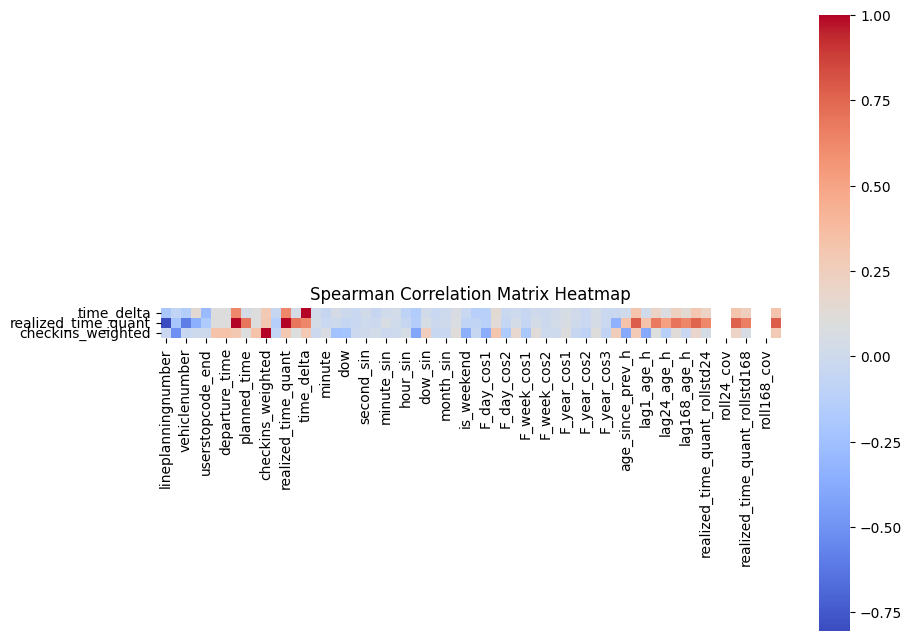

In [88]:
corr_columns = ['time_delta','realized_time_quant','checkins_weighted']

plot_corr_heatmap(
    dfs_final_set['merged'],
    method='spearman',
    min_value_threshold=0.15,
    annot=False,
    y_axis_columns=corr_columns
)


### Feature Engineering

### ML Pipeline

In [89]:
dfs_final_set['merged'].columns

Index(['lineplanningnumber', 'journeynumber', 'vehiclenumber',
       'userstopcode_start', 'userstopcode_end', 'messagetype_begin',
       'messagetype_end', 'operatingday', 'departure_time', 'realized_time',
       'planned_time', 'ceiling_hour', 'checkins_weighted',
       'checkins_weighted_coverage', 'userstopareacode_start',
       'stopname_start', 'userstopareacode_end', 'stopname_end',
       'realized_time_quant', 'planned_time_quant', 'time_delta', 'direction',
       'line_key', 'second', 'minute', 'hour', 'dow', 'month', 'second_sin',
       'second_cos', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'is_weekend',
       'F_day_sin1', 'F_day_cos1', 'F_day_sin2', 'F_day_cos2', 'F_week_sin1',
       'F_week_cos1', 'F_week_sin2', 'F_week_cos2', 'F_year_sin1',
       'F_year_cos1', 'F_year_sin2', 'F_year_cos2', 'F_year_sin3',
       'F_year_cos3', 'hist_n', 'age_since_prev_h', 'realized_time_quant_lag1',
       'ind_

In [90]:
TARGET = "realized_time_quant"            # <- your label column
TIMESTAMP_COL = "operatingday"         # <- used only for splitting/sanity checks

# Choose the raw columns you want the user to provide at predict time.
# You can list them explicitly, or pick programmatically.
RAW_NUMERIC_COLS = [
    # examples
        'planned_time_quant', 'checkins_weighted',
        'second_sin','second_cos', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos',
        'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'is_weekend',
        'F_day_sin1', 'F_day_cos1', 'F_day_sin2', 'F_day_cos2', 'F_week_sin1',
        'F_week_cos1', 'F_week_sin2', 'F_week_cos2', 'F_year_sin1',
        'F_year_cos1', 'F_year_sin2', 'F_year_cos2', 'F_year_sin3',
        'F_year_cos3','hist_n', 'age_since_prev_h','realized_time_quant_lag1',
        'ind_miss_lag1', 'lag1_age_h', 'realized_time_quant_lag24',
        'ind_miss_lag24', 'lag24_age_h', 'realized_time_quant_lag168',
        'ind_miss_lag168', 'lag168_age_h', 'realized_time_quant_rollmean24',
        'realized_time_quant_rollstd24', 'roll24_n', 'roll24_cov',
        'realized_time_quant_rollmean168', 'realized_time_quant_rollstd168',
        'roll168_n', 'roll168_cov', 'ind_warmup', 'realized_time_quant_t+1'
]
RAW_CATEGORICAL_COLS = [
    # examples
    'lineplanningnumber', 'direction','line_key'
]

REQUIRED_RAW_FEATURES = RAW_NUMERIC_COLS + RAW_CATEGORICAL_COLS

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Tree model preprocessor: trees don’t need scaling
numeric_tree = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
])

categorical_common = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=None, sparse_output=False)),
])

preprocess_for_trees = ColumnTransformer(
    transformers=[
        ("num", numeric_tree, RAW_NUMERIC_COLS),
        ("cat", categorical_common, RAW_CATEGORICAL_COLS),
    ],
    remainder="drop",
)

# Linear model preprocessor: scale numerics for better optimization
numeric_linear = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
])

preprocess_for_linear = ColumnTransformer(
    transformers=[
        ("num", numeric_linear, RAW_NUMERIC_COLS),
        ("cat", categorical_common, RAW_CATEGORICAL_COLS),
    ],
    remainder="drop",
)


In [93]:
from sklearn.ensemble import HistGradientBoostingRegressor

gb_model = HistGradientBoostingRegressor(
    max_iter=500,
    learning_rate=0.05,
    max_depth=None,        # let leaves control complexity
    max_leaf_nodes=31,
    l2_regularization=0.0,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
)

gb_pipeline = Pipeline([
    ("prep", preprocess_for_trees),
    ("model", gb_model),
])


In [94]:
from sklearn.linear_model import QuantileRegressor

# One pipeline per quantile (example: median)
q = 0.5  # 0.5 = median, 0.9 = 90th percentile
qreg_model = QuantileRegressor(quantile=q, alpha=1.0, fit_intercept=True)

qreg_pipeline = Pipeline([
    ("prep", preprocess_for_linear),
    ("model", qreg_model),
])

In [95]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

def time_cv_score(df, pipeline, n_splits=5):
    require_columns(df, REQUIRED_RAW_FEATURES + [TARGET, TIMESTAMP_COL])
    df = df.sort_values(TIMESTAMP_COL)

    X = df[REQUIRED_RAW_FEATURES]
    y = df[TARGET].to_numpy()

    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    for train_idx, test_idx in tscv.split(X):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        pipeline.fit(X_tr, y_tr)
        pred = pipeline.predict(X_te)
        scores.append(mean_absolute_error(y_te, pred))
    return scores

In [96]:
dfs_final_set['merged'][RAW_CATEGORICAL_COLS].dtypes

lineplanningnumber    category
direction             category
line_key              category
dtype: object

In [ ]:
# Train on your chosen train window
cutoff_test_date = "2024-01-01"
df_train = data_cutoff_dates(dfs_final_set['merged'], col_datetime=TIMESTAMP_COL, start_date='2020-01-01', end_date=cutoff_test_date)
X_train = df_train[REQUIRED_RAW_FEATURES]
y_train = df_train[TARGET]

gb_pipeline.fit(X_train, y_train)
qreg_pipeline.fit(X_train, y_train)

# Predict on future (same required columns)
df_future = data_cutoff_dates(dfs_final_set['merged'], col_datetime=TIMESTAMP_COL, start_date=cutoff_test_date, end_date='2030-01-01')
X_future = df_future[REQUIRED_RAW_FEATURES]

y_pred_gb   = gb_pipeline.predict(X_future)  # point prediction
y_pred_q50  = qreg_pipeline.predict(X_future)  # median prediction